In [ ]:
#!pip install GPUtil

### Summary about this notebook

In this notebook, we read the train and test dataset provided as part of Booking Challenge. To run this on a local GPU with 4GB memory, we needed to reduce the data size.

We used Random library to generate random numbers to select 5% of trips from each dataset csv file. We then combined the two datasets and further filtered out trips with only single city booking or trips with more than 5 cities to get a manageable dataset.

This final dataset will be used for further operations such as generating sequential data and model training.

In [2]:
import pandas as pd
import cudf

In [16]:
import torch, gc
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from sklearn.model_selection import GroupKFold

pd.__version__, cudf.__version__

('1.3.5', '22.08.00')

In [26]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    gc.collect()
    torch.cuda.empty_cache()

    cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 95% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 93% |


In [27]:
print(torch.cuda.current_device())

0


In [3]:
df_train=pd.read_csv("train_set.csv")
df_test=pd.read_csv("test_set.csv")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166835 entries, 0 to 1166834
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   user_id         1166835 non-null  int64 
 1   checkin         1166835 non-null  object
 2   checkout        1166835 non-null  object
 3   city_id         1166835 non-null  int64 
 4   device_class    1166835 non-null  object
 5   affiliate_id    1166835 non-null  int64 
 6   booker_country  1166835 non-null  object
 7   hotel_country   1166835 non-null  object
 8   utrip_id        1166835 non-null  object
dtypes: int64(3), object(6)
memory usage: 80.1+ MB


In [9]:
trips_train=df_train['utrip_id'].unique()
trips_test=df_test['utrip_id'].unique()

In [7]:
import random

In [10]:
random_trips_train=random.sample(trips_train.tolist(),len(trips_train)//20)

In [11]:
random_trips_test=random.sample(trips_test.tolist(),len(trips_test)//20)

In [12]:
train_ex=df_train[df_train['utrip_id'].isin(random_trips_train)]
test_ex=df_test[df_test['utrip_id'].isin(random_trips_test)]

In [13]:
train_ex.to_csv( 'train.csv', index=False )
test_ex.to_csv( 'test.csv', index=False )

In [14]:
train = pd.read_csv('train.csv').sort_values(by=['user_id','checkin'])
test = pd.read_csv('test.csv').sort_values(by=['user_id','checkin'])
#del train['Unnamed: 0']
#del test['row_num'], test['total_rows']

print(train.shape, test.shape)
train.head()

(58485, 9) (18893, 9)


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
20708,29,2016-07-09,2016-07-11,47054,desktop,1601,Elbonia,Elbonia,29_1
20709,29,2016-07-11,2016-07-13,34444,desktop,1601,Elbonia,Elbonia,29_1
20710,29,2016-07-13,2016-07-16,12291,desktop,1601,Elbonia,Elbonia,29_1
20711,29,2016-07-16,2016-07-18,16386,desktop,8132,Elbonia,Elbonia,29_1
5159,149,2017-02-03,2017-02-05,10485,desktop,3417,The Devilfire Empire,Kangan,149_1


In [4]:


def get_order_in_group(utrip_id_,order):
    for i in range(cuda.threadIdx.x, len(utrip_id_), cuda.blockDim.x):
        order[i] = i

def add_cumcount(df, sort_col, outputname):
    df = df.sort_values(sort_col, ascending=True)
    tmp = df[['utrip_id_', 'checkin']].groupby(['utrip_id_']).apply_grouped(
        get_order_in_group,incols=['utrip_id_'],
        outcols={'order': 'int32'},
        tpb=32)
    tmp.columns = ['utrip_id_', 'checkin', outputname]
    df = df.merge(tmp, how='left', on=['utrip_id_', 'checkin'])
    df = df.sort_values(sort_col, ascending=True)
    return(df)

In [5]:
df_train['istest'] = 0
df_test['istest'] = 1
raw = pd.concat([df_train,df_test], sort=False )
raw = raw.sort_values( ['user_id','checkin'], ascending=True )
raw.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest
413669,29,2016-07-09,2016-07-11,47054,desktop,1601,Elbonia,Elbonia,29_1,0
413670,29,2016-07-11,2016-07-13,34444,desktop,1601,Elbonia,Elbonia,29_1,0
413671,29,2016-07-13,2016-07-16,12291,desktop,1601,Elbonia,Elbonia,29_1,0
413672,29,2016-07-16,2016-07-18,16386,desktop,8132,Elbonia,Elbonia,29_1,0
355509,65,2016-09-26,2016-09-29,36403,desktop,3577,The Devilfire Empire,Cobra Island,65_1,1


In [6]:
raw.loc[ (raw.city_id==0)]

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest
355513,65,2016-10-03,2016-10-04,0,mobile,4132,The Devilfire Empire,NaN,65_1,1
356899,67,2016-08-11,2016-08-14,0,desktop,9924,Tcherkistan,NaN,67_1,1
10963,115,2016-04-06,2016-04-07,0,desktop,9924,Elbonia,NaN,115_1,1
120565,279,2016-03-27,2016-04-01,0,desktop,2803,Tcherkistan,NaN,279_1,1
139366,307,2016-06-02,2016-06-03,0,desktop,8132,Elbonia,NaN,307_1,1
...,...,...,...,...,...,...,...,...,...,...
353170,6257974,2016-07-05,2016-07-07,0,tablet,7974,The Devilfire Empire,NaN,6257974_1,1
353174,6258010,2016-06-10,2016-06-12,0,mobile,359,The Devilfire Empire,NaN,6258010_1,1
353181,6258104,2016-08-25,2016-08-27,0,mobile,359,Gondal,NaN,6258104_4,1
353186,6258120,2016-07-24,2016-07-25,0,desktop,9924,Gondal,NaN,6258120_1,1


raw['fold'] = 0
group_kfold = GroupKFold(n_splits=5)
for fold, (train_index, test_index) in enumerate(group_kfold.split(X=raw, y=raw, groups=raw['utrip_id'])):
    raw.iloc[test_index,10] = fold

raw['fold'].value_counts()


In [7]:
#This flag tell which row must be part of the submission file.

raw['submission'] = 0
raw.loc[ (raw.city_id==0)&(raw.istest) ,'submission'] = 1

raw.loc[ raw.submission==1] 

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,submission
355513,65,2016-10-03,2016-10-04,0,mobile,4132,The Devilfire Empire,NaN,65_1,1,1
356899,67,2016-08-11,2016-08-14,0,desktop,9924,Tcherkistan,NaN,67_1,1,1
10963,115,2016-04-06,2016-04-07,0,desktop,9924,Elbonia,NaN,115_1,1,1
120565,279,2016-03-27,2016-04-01,0,desktop,2803,Tcherkistan,NaN,279_1,1,1
139366,307,2016-06-02,2016-06-03,0,desktop,8132,Elbonia,NaN,307_1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
353170,6257974,2016-07-05,2016-07-07,0,tablet,7974,The Devilfire Empire,NaN,6257974_1,1,1
353174,6258010,2016-06-10,2016-06-12,0,mobile,359,The Devilfire Empire,NaN,6258010_1,1,1
353181,6258104,2016-08-25,2016-08-27,0,mobile,359,Gondal,NaN,6258104_4,1,1
353186,6258120,2016-07-24,2016-07-25,0,desktop,9924,Gondal,NaN,6258120_1,1,1


In [8]:
#number of places visited in each trip

aggs = raw.groupby('utrip_id', as_index=False)['user_id'].count().reset_index(drop=True)
aggs.columns = ['utrip_id', 'N']
raw = raw.merge(aggs, on=['utrip_id'], how='inner')

In [11]:
raw['utrip_id_'], mp = raw['utrip_id'].factorize()

In [13]:
raw['utrip_id'].factorize()

(array([     0,      0,      0, ..., 288347, 288347, 288347]),
 Index(['29_1', '65_1', '67_1', '81_1', '115_1', '136_2', '136_4', '149_1',
        '156_1', '160_1',
        ...
        '6257974_1', '6257979_1', '6258010_1', '6258017_1', '6258041_1',
        '6258065_1', '6258087_1', '6258104_4', '6258120_1', '6258185_1'],
       dtype='object', length=288348))

In [23]:
raw=cudf.from_pandas(raw)

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/junaid_id/anaconda3/envs/rapids-22.08/include/rmm/mr/device/cuda_memory_resource.hpp

In [12]:
raw = add_cumcount(raw, ['utrip_id_','checkin'], 'dcount')

AttributeError: 'DataFrameGroupBy' object has no attribute 'apply_grouped'

In [25]:
raw['icount'] = raw['N']-raw['dcount']-1

In [26]:
raw.head(50)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,submission,N,utrip_id_,dcount,icount
16,29,2016-07-09,2016-07-11,47054,desktop,1601,Elbonia,Elbonia,29_1,0,0,4,0,0,3
17,29,2016-07-11,2016-07-13,34444,desktop,1601,Elbonia,Elbonia,29_1,0,0,4,0,1,2
18,29,2016-07-13,2016-07-16,12291,desktop,1601,Elbonia,Elbonia,29_1,0,0,4,0,2,1
19,29,2016-07-16,2016-07-18,16386,desktop,8132,Elbonia,Elbonia,29_1,0,0,4,0,3,0
20,149,2017-02-03,2017-02-05,10485,desktop,3417,The Devilfire Empire,Kangan,149_1,0,0,4,1,0,3
21,149,2017-02-05,2017-02-06,10485,desktop,3417,The Devilfire Empire,Kangan,149_1,0,0,4,1,1,2
22,149,2017-02-06,2017-02-07,10485,desktop,3417,The Devilfire Empire,Kangan,149_1,0,0,4,1,2,1
23,149,2017-02-07,2017-02-09,28733,desktop,5583,The Devilfire Empire,Kangan,149_1,0,0,4,1,3,0
24,958,2016-08-30,2016-08-31,25392,desktop,9924,Gondal,Mypos,958_1,0,0,4,2,0,3
25,958,2016-08-31,2016-09-01,11675,desktop,9924,Gondal,Mypos,958_1,0,0,4,2,1,2


In [13]:
raw.to_csv( 'train_and_test_full.csv', index=False )

In [25]:
free_gpu_cache()

NameError: name 'free_gpu_cache' is not defined

In [40]:
torch.cuda.empty_cache()

In [38]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [36]:
#del  raw
#del  train
#del test
gc.collect()

0

In [42]:
import os, sys

VER = 44
os.environ["CUDA_VISIBLE_DEVICES"]="0"


TRAIN_WITH_TEST = True
# ONLY DO THIS MANY FOLDS
DO_FOLDS = 5
# MAKE SUBMISSION OR NOT
DO_TEST = True

In [34]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import cudf
import cupy
import gc
from sklearn.model_selection import GroupKFold
pd.set_option('display.max_columns', None)

pd.__version__, cudf.__version__

('1.3.5', '22.08.00')

In [29]:
#!pip install matplotlib

In [35]:
# Return top4 metric
# istest: flag to select if metric should be computed in 0:train, 1:test, -1:both
# pos: select which city to calculate the metric, 0: last, 1: last-1, 2:last-2 , -1: all
# the input `val` dataframe must contains the target `city_id` and the 4 recommendations as: rec0, res1, rec2 and rec3

def top4_metric( val, istest=0, pos=0 , target='city_id'):
    
    if istest>=0:
        val = val.loc[ (val.submission==0) & (val.istest == istest) ]
    else:
        val = val.loc[ (val.submission==0) ]

    if pos >= 0:
        top1 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec0']
        top2 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec1']
        top3 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec2']
        top4 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec3']
    else:
        top1 = val[target] == val['rec0']
        top2 = val[target] == val['rec1']
        top3 = val[target] == val['rec2']
        top4 = val[target] == val['rec3']
        
    return (top1|top2|top3|top4).mean()    

In [36]:
%%time
PATH = './'
raw = cudf.read_csv('train_and_test_2.csv')
print(raw.shape)

(77163, 15)
CPU times: user 5.73 ms, sys: 25.1 ms, total: 30.8 ms
Wall time: 33.1 ms


In [37]:
raw['reverse'] = 0
raw.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,submission,N,utrip_id_,dcount,icount,reverse
0,156,2016-08-13,2016-08-15,2748,mobile,359,Gondal,Leutonia,156_1,0,0,8,0,0,7,0
1,156,2016-08-15,2016-08-16,16546,mobile,359,Gondal,Kazahrus,156_1,0,0,8,0,1,6,0
2,156,2016-08-16,2016-08-17,48310,mobile,359,Gondal,Leutonia,156_1,0,0,8,0,2,5,0
3,156,2016-08-17,2016-08-18,39132,mobile,359,Gondal,Kazahrus,156_1,0,0,8,0,3,4,0
4,156,2016-08-18,2016-08-19,41971,mobile,359,Gondal,Urkesh,156_1,0,0,8,0,4,3,0


In [38]:
reverse = raw.copy()
reverse['reverse'] = 1
reverse['utrip_id'] = reverse['utrip_id']+'_r'

In [39]:
reverse['icount'] = reverse['dcount'].copy()

In [40]:
reverse = reverse.sort_values(['utrip_id', 'icount'], ascending=False)
raw = cudf.concat([raw, reverse], axis=0)
raw['sorting'] = cupy.asarray(range(raw.shape[0]))
del reverse
gc.collect()

146

In [41]:
raw['utrip_id'+'_'], mp = raw['utrip_id'].factorize()

In [42]:
%%time

raw['checkin'] = cudf.to_datetime(raw.checkin, format="%Y-%m-%d")
raw['checkout'] = cudf.to_datetime(raw.checkout, format="%Y-%m-%d")

CPU times: user 4.22 ms, sys: 4.12 ms, total: 8.34 ms
Wall time: 7.07 ms


In [43]:
%%time

# ENGINEER MONTH, WEEKDAY, and LENGTH OF STAY FEATURES
raw['mn'] = raw.checkin.dt.month
raw['dy1'] = raw.checkin.dt.weekday
raw['dy2'] = raw.checkout.dt.weekday
raw['length'] = (raw.checkout - raw.checkin).dt.days

# ENGINEER WEEKEND AND SEASON
raw['day_name']= raw.checkin.dt.weekday
raw['isweekend']=raw['day_name'].isin([5,6]).astype('int8')

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 17.3 ms


In [44]:
df_season = cudf.DataFrame({'mn': range(1,13), 'season': ([0]*3)+([1]*3)+([2]*3)+([3]*3)})

In [45]:
raw=raw.merge(df_season, how='left', on='mn')
raw = raw.sort_values(['sorting'], ascending=True)

In [46]:
def shift_feature(df, groupby_col, col, offset, nan=-1, colname=''):
    df[colname] = df[col].shift(offset)
    df.loc[df[groupby_col]!=df[groupby_col].shift(offset), colname] = nan

In [47]:
# WEIRD FEATURE IS DIFFERENT FOR REVERSE AND NORMAL
shift_feature(raw, 'utrip_id_', 'checkout', 1, None, 'checkout_lag1')
raw['gap'] = (raw.checkin - raw.checkout_lag1).dt.days.fillna(-1) 

In [48]:
%%time

# REVERSE ICOUNT
raw['dcount'] = raw['N']-raw['icount']-1

CPU times: user 0 ns, sys: 2.56 ms, total: 2.56 ms
Wall time: 1.83 ms


In [49]:
# LABEL ENCODE CATEGORICAL
CATS = ['city_id','mn','dy1','dy2','length','device_class','affiliate_id','booker_country',
        'hotel_country','icount','dcount','gap','isweekend', 'season']
MAPS = []
for c in CATS:
    raw[c+'_'], mp = raw[c].factorize()
    MAPS.append(mp)
    print('created',c+'_')

created city_id_
created mn_
created dy1_
created dy2_
created length_
created device_class_
created affiliate_id_
created booker_country_
created hotel_country_
created icount_
created dcount_
created gap_
created isweekend_
created season_


In [50]:
LAGS = 5
EC = 400

# ENGINEER LAG FEATURES
for i in range(1,LAGS+1):
    shift_feature(raw, 'utrip_id_', 'city_id_', i, -1, f'city_id_lag{i}')

In [51]:
shift_feature(raw, 'utrip_id_', 'hotel_country_', i, -1, 'hotel_lag1')

In [52]:
# TOTAL DURATION AND FIRST CITY
tmpA = raw[raw['icount']==0][['utrip_id', 'checkout']]
tmpB = raw[raw['dcount']==0][['utrip_id', 'checkin']]
tmpC = tmpA.merge(tmpB, how='left', on='utrip_id')
tmpC['length_total'] = (tmpC['checkout'] - tmpC['checkin']).dt.days
raw = raw.merge(tmpC[['utrip_id', 'length_total']],on='utrip_id',how='left')

In [53]:
tmpD = raw[raw['dcount']==0][['utrip_id', 'city_id_']]
tmpD.columns = ['utrip_id', 'city_first']
raw = raw.merge(tmpD,on='utrip_id',how='left')

In [63]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 14% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 13% |


In [54]:
tmpA = raw[raw['dcount']==0][['utrip_id', 'checkout']]
tmpB = raw[raw['icount']==0][['utrip_id', 'checkin']]
tmpC = tmpA.merge(tmpB, how='left', on='utrip_id')
tmpC['length_total_r'] = (tmpC['checkout'] - tmpC['checkin']).dt.days
raw = raw.merge(tmpC[['utrip_id', 'length_total_r']],on='utrip_id',how='left')
raw.loc[raw['length_total']<0,'length_total'] = raw.loc[raw['length_total']<0,'length_total_r']

In [65]:
raw[raw['utrip_id'].isin(['999944_1','999944_1_r'])]

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r


In [55]:
# CONVERT -1 TO 0
cols = [f'city_id_lag{i}' for i in range(LAGS,0,-1)]
for c in cols+['city_id_','city_first']+['hotel_lag1']:
    raw[c] += 1
    print(c)

city_id_lag5
city_id_lag4
city_id_lag3
city_id_lag2
city_id_lag1
city_id_
city_first
hotel_lag1


In [56]:
# MOVE RARE CITIES INTO COMMON CLASS
RARE = 9*2 #x2 because data has doubled
tmp = raw.city_id_.value_counts()
idx = tmp.loc[tmp<=RARE].index.values
print('rare city ct under <=%i'%RARE, len(idx),'total cities =',len(tmp) )

mx = raw.city_id_.max()+1
for c in cols+['city_first']:
    raw.loc[raw[c].isin(idx),c] = mx

rare city ct under <=18 10618 total cities = 11852


In [57]:
# VERIFY LAG LOOKS RIGHT
raw[['city_id_','city_id_','icount']+cols].head()

,city_id_,icount,city_id_lag5,city_id_lag4,city_id_lag3,city_id_lag2,city_id_lag1
0,6703,1,0,11853,11853,11853,4883
1,1366,0,11853,11853,11853,4883,6703
2,1528,4,0,0,0,0,0
3,964,3,0,0,0,0,1528
4,2433,2,0,0,0,1528,964


In [58]:
FEATURES = ['mn_', 'dy1_','dy2_','length_','device_class_',  'affiliate_id_', 'booker_country_',
       'hotel_lag1','icount','dcount','city_first','length_total','gap_','isweekend_', 'season_'] + cols
TARGET = ['city_id_']

In [70]:
os.environ['TF_MEMORY_ALLOCATION'] = "0.6" # fraction of free memory

In [59]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [60]:
gpus = tf.config.list_physical_devices('GPU')

2022-12-27 14:03:45.843671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 14:03:45.846476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 14:03:45.846831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [61]:
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*20)]
)

In [62]:
# EMBEDDING INPUT SIZES
cts = []
for c in FEATURES:
    mx = raw[c].max()
    cts.append(mx+1)
    print(c,mx+1)

mn_ 12
dy1_ 7
dy2_ 7
length_ 21
device_class_ 3
affiliate_id_ 1020
booker_country_ 5
hotel_lag1 144
icount 35
dcount 35
city_first 11854
length_total 85
gap_ 39
isweekend_ 2
season_ 4
city_id_lag5 11854
city_id_lag4 11854
city_id_lag3 11854
city_id_lag2 11854
city_id_lag1 11854


In [63]:
# EMBEDDING OUTPUT SIZES
#EC = 400
cts2 = [4,3,3,6,2,60,3,14,7,7,200,18,9,3,4]+[EC]*len(cols)

In [64]:
emb_map = {i:(j,k) for i,j,k in zip(FEATURES, cts, cts2)}
emb_map

{'mn_': (12, 4),
 'dy1_': (7, 3),
 'dy2_': (7, 3),
 'length_': (21, 6),
 'device_class_': (3, 2),
 'affiliate_id_': (1020, 60),
 'booker_country_': (5, 3),
 'hotel_lag1': (144, 14),
 'icount': (35, 7),
 'dcount': (35, 7),
 'city_first': (11854, 200),
 'length_total': (85, 18),
 'gap_': (39, 9),
 'isweekend_': (2, 3),
 'season_': (4, 4),
 'city_id_lag5': (11854, 400),
 'city_id_lag4': (11854, 400),
 'city_id_lag3': (11854, 400),
 'city_id_lag2': (11854, 400),
 'city_id_lag1': (11854, 400)}

In [65]:
# TARGET SOFTMAX OUTPUT SIZE
t_ct = raw['city_id_'].max()+1
t_ct

11853

In [76]:
raw.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,submission,N,utrip_id_,dcount,icount,reverse,sorting,mn,dy1,dy2,length,dy2_,length_,device_class_,affiliate_id_,booker_country_,hotel_country_,icount_,dcount_,gap_,isweekend_,season_,city_id_lag1,city_id_lag2,city_id_lag3,city_id_lag4,city_id_lag5,hotel_lag1,length_total,city_first,length_total_r
0,102239,2016-03-25,2016-03-26,38124,desktop,253,Elbonia,Bozatta,102239_1,0,0,6,124,4,1,0,1424,3,4,5,1,5,0,0,37,1,22,1,4,27,0,0,4883,11853,11853,11853,0,0,7,11853,-5
1,102239,2016-03-26,2016-03-27,7942,desktop,5357,Elbonia,Bozatta,102239_1,0,0,6,124,5,0,0,1425,3,5,6,1,6,0,0,557,1,22,0,5,27,1,0,6703,4883,11853,11853,11853,23,7,11853,-5
2,102276,2016-07-18,2016-07-21,8938,desktop,9924,Gondal,Gondal,102276_1,1,0,5,126,0,4,0,1426,7,0,3,3,3,2,0,948,2,53,4,0,26,0,2,0,0,0,0,0,0,10,1528,-6
3,102276,2016-07-21,2016-07-23,5612,desktop,9924,Gondal,Glubbdubdrib,102276_1,1,0,5,126,1,3,0,1427,7,3,5,2,5,1,0,948,2,52,3,1,27,0,2,1528,0,0,0,0,0,10,1528,-6
4,102276,2016-07-23,2016-07-25,14104,mobile,9452,Gondal,Gondal,102276_1,1,0,5,126,2,2,0,1428,7,5,0,2,0,1,1,910,2,53,2,2,27,1,2,964,1528,0,0,0,0,10,1528,-6


In [66]:
N_CITY = 70

class Linear(tf.keras.layers.Layer):
    def __init__(self, H, activation='relu'):
        super(Linear, self).__init__()
        self.dense = tf.keras.layers.Dense(H)
        self.bn = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation(activation)

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x
    

class WeightedSum(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightedSum, self).__init__(name='weighted_sum')

    def build(self, input_shape):
        self.w1 = self.add_weight(name='w1',shape=None,dtype=tf.float32,
                                 trainable=True)
        self.w2 = self.add_weight(name='w2',shape=None,dtype=tf.float32,
                                 trainable=True)
        
    def call(self, x1, x2, x3):
        w1 = tf.nn.sigmoid(self.w1)
        w2 = tf.nn.sigmoid(self.w2)
        x1 = tf.stop_gradient(x1)
        x2 = tf.stop_gradient(x2)
        x3 = tf.stop_gradient(x3)
        return (x1 + x2*w1 + x3*w2)/(1+w1+w2)
    
class EmbDotSoftMax(tf.keras.layers.Layer):
    def __init__(self):
        super(EmbDotSoftMax, self).__init__()
        self.d1 = tf.keras.layers.Dense(EC) 
    
    def call(self, x, top_city_emb, top_city_id, prob):
        emb_pred = self.d1(x) # B,EC
        emb_pred = tf.expand_dims(emb_pred, axis=1) #B,1,EC
        x = emb_pred*top_city_emb #B,N_CITY,EC
        x = tf.math.reduce_sum(x, axis=2) #B,N_CITY
        x = tf.nn.softmax(x) #B,N_CITY

        rowids = tf.range(0,tf.shape(x)[0]) # B
        rowids = tf.transpose(tf.tile([rowids],[N_CITY,1])) # B,N_CITY

        idx = tf.stack([rowids,top_city_id],axis=2) # B, N_CITY, 2
        idx = tf.cast(idx, tf.int32)
        prob = tf.scatter_nd(idx, x, tf.shape(prob)) + 1e-6
        return prob
    

def build_model():
    inp = tf.keras.layers.Input(shape=(len(FEATURES),))
    embs = []
    i,j = emb_map['city_id_lag1']
    e_city = tf.keras.layers.Embedding(i,j)
    city_embs = []
    
    for k,f in enumerate(FEATURES):
        i,j = emb_map[f]
        if f.startswith('city_id'):
            city_embs.append(e_city(inp[:,k]))
        else:
            e = tf.keras.layers.Embedding(i,j)
            embs.append(e(inp[:,k]))
    
    xc = tf.stack(city_embs, axis=1) # B, T, F
    xc = tf.keras.layers.GRU(EC, activation='tanh')(xc)
    
    x = tf.keras.layers.Concatenate()(embs)
    x = tf.keras.layers.Concatenate()([x,xc])
    
    x1 = Linear(512+256, 'relu')(x)
    x2 = Linear(512+256, 'relu')(x1)
    prob = tf.keras.layers.Dense(t_ct,activation='softmax',name='main_output')(x2)
    
    _, top_city_id = tf.math.top_k(prob, N_CITY)  # top_city_id.shape = B,N_CITY
    top_city_emb = e_city(top_city_id) # B,N_CITY,EC
    
    x1 = Linear(512+256, 'relu')(x1)
    prob_1 = EmbDotSoftMax()(x1,top_city_emb,top_city_id,prob)
    prob_2 = EmbDotSoftMax()(x2,top_city_emb,top_city_id,prob)
    
    prob_ws = WeightedSum()(prob, prob_1, prob_2)
    
    model = tf.keras.models.Model(inputs=inp,outputs=[prob,prob_1,prob_2,prob_ws])
    opt = tf.keras.optimizers.Adam(lr=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    mtr = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=4)
    model.compile(loss=loss, optimizer = opt, metrics=[mtr])
    return model

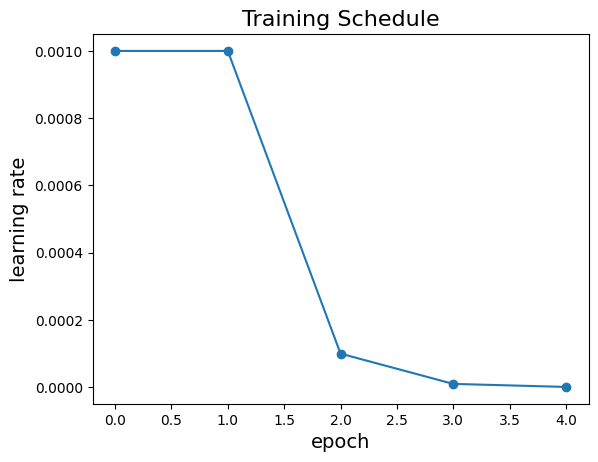

In [67]:
# CUSTOM LEARNING SCHEUDLE

def lrfn(epoch):
    rates = [1e-3,1e-3,1e-4,1e-5,1e-6]
    return rates[epoch]
    
lr = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(5)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y,'-o'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

In [71]:
!pip install keras

In [68]:
WEIGHT_PATH = './'

In [69]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from tensorflow.keras.models import Model


In [70]:
gc.collect()

3586

In [75]:
for fold in range(5):
       
    print('#'*25)
    print('### FOLD %i'%(fold+1))
    
    # TRAIN DATA
    train = raw.loc[ (raw.dcount>0)&(raw.istest==0) ].copy()
        
    # VALIDATION DATA
    valid = raw.loc[ (raw.istest==0)&(raw.icount==0)&(raw.N>=4)&(raw.reverse==0) ].copy()

    print('### train shape',train.shape,'valid shape', valid.shape)    
    print('#'*25)
        
    # SAVE BEST VAL SCORE EPOCH MODEL
    sv = tf.keras.callbacks.ModelCheckpoint(
        monitor='val_weighted_sum_sparse_top_k_categorical_accuracy', verbose=1, 
        save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch'
    )
        
    model = build_model()
    model.fit(train[FEATURES].to_pandas(),train[TARGET].to_pandas(),
          validation_data = (valid[FEATURES].to_pandas(),valid[TARGET].to_pandas()),
          epochs=5,verbose=1,batch_size=512, callbacks=[sv,lr])
    del train, valid
    gc.collect()

#########################
### FOLD 1
### train shape (94754, 49) valid shape (10834, 49)
#########################


TypeError: __init__() missing 1 required positional argument: 'filepath'

In [85]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 78% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 78% |
